# Notebook 4 - Property modeling with conventional molecular descriptors

By Vincent Blay, November 2021

This notebooks illustrates the use of conventional molecular descriptors from rdkit to model different molecular properties in this work.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors, MolFromSmiles
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

%run "./plotting.py"

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
def smiles_to_descriptors(smiles):
    smiles = list(smiles)
    names = [x[0] for x in Descriptors._descList]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator(names)

    idx = []
    D = []
    for i in range(len(smiles)):
        smi = smiles[i]
        mol = MolFromSmiles(smi)
        if mol is not None:
            descriptors = calc.CalcDescriptors(mol)
            D.append(descriptors)
            idx.append(i)

    D = pd.to_numeric(D, errors='coerce') # converts any string to nan

    # Let us now remove columns with any nan value
    D = pd.DataFrame(D)
    D.columns = names
    D[abs(D) > 1e5] = np.nan
    D.dropna(axis=1, how='any', inplace=True)
    
    # Let us also remove columns with very small standard deviation
    sd = D.std(axis=1)
    D.drop(np.where(sd<0.001)[0],axis=1)
    
    return D, idx

## Research Octane Number (RON)

Let us load the data and look at the distribution:

In [4]:
df = pd.read_csv("../data/data_RON.csv")
smiles = df.Smiles
Y = df.RON
print(len(smiles))

194


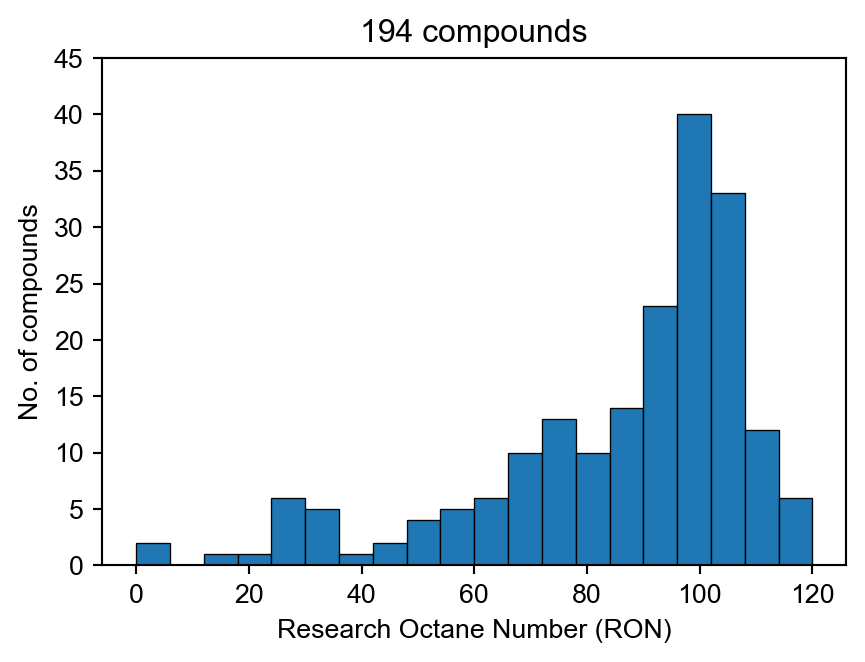

In [5]:
plot_histogram(Y, xlabel="Research Octane Number (RON)")

Let us now compute the molecular descriptors:

In [6]:
D, idx = smiles_to_descriptors(smiles)

Y = Y[idx]

In [7]:
D.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,2.1875,0.369792,2.1875,0.369792,0.408425,98.189,84.077,98.10955,42,0,...,0,0,0,0,0,0,0,0,0,0
1,2.253472,0.852963,2.253472,0.852963,0.492217,112.216,96.088,112.125201,48,0,...,0,0,0,0,0,0,0,0,0,0
2,10.243056,0.453704,10.243056,0.453704,0.42968,84.118,76.054,84.057515,34,0,...,0,0,0,0,0,0,0,0,0,0
3,1.5,1.5,1.5,1.5,0.408362,70.135,60.055,70.07825,30,0,...,0,0,0,0,0,0,0,0,0,0
4,1.5,1.5,1.5,1.5,0.422316,84.162,72.066,84.0939,36,0,...,0,0,0,0,0,0,0,0,0,0


Let us split the data in training and validation sets:

In [8]:
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)

Now we want to select those descriptors that we will use to train the model.

In [9]:
%%time

regr = LinearRegression()

sfs = SequentialFeatureSelector(regr, n_features_to_select=15)
sfs.fit(D_train, y_train)
print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}")

Features selected by forward sequential selection: ['MaxEStateIndex', 'MinEStateIndex', 'BalabanJ', 'Chi3n', 'PEOE_VSA10', 'PEOE_VSA6', 'SMR_VSA5', 'SlogP_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA8', 'VSA_EState5', 'FractionCSP3', 'NumRotatableBonds', 'fr_unbrch_alkane']
Wall time: 51.9 s


In [10]:
D_train.shape

(155, 208)

Now we use the selected descriptors to train a Support Vector Regressor (SVR) from the `sklearn` package.

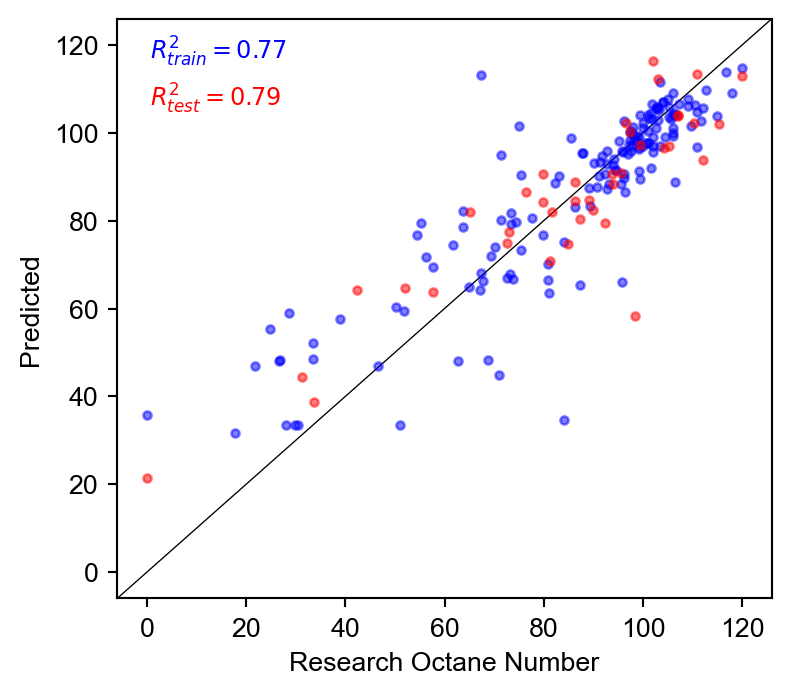

In [11]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel='rbf', C=100, epsilon=3)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Research Octane Number", savetitle="../results/rdkit/rdkit_RON.svg") 

## Cetane Number (CN)

In [12]:
df = pd.read_csv("../data/data_CN.csv")
smiles = df.Smiles
Y = df.CN
print(len(smiles))

545


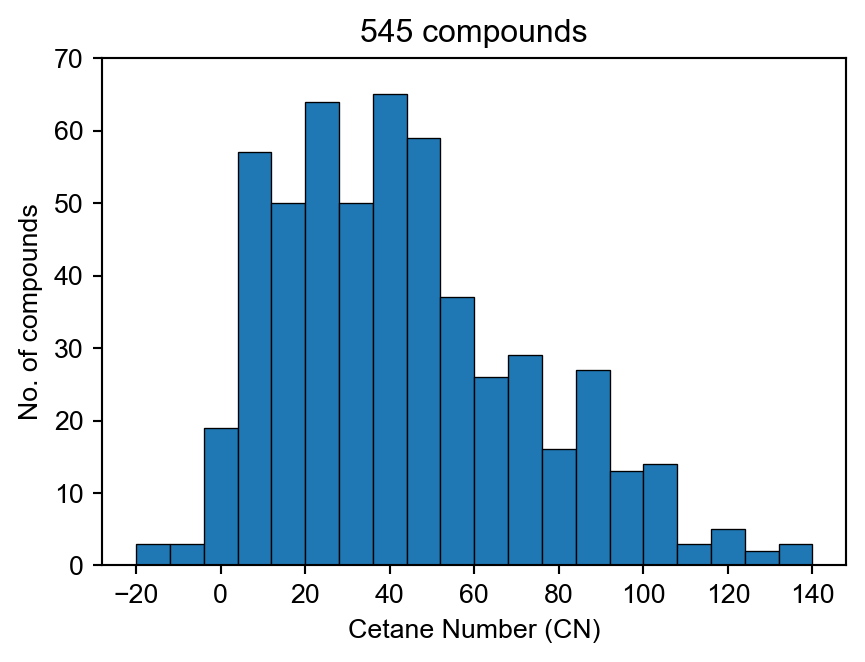

In [13]:
plot_histogram(Y, xlabel="Cetane Number (CN)")

In [14]:
D, idx = smiles_to_descriptors(smiles)

Y = Y[idx]

In [15]:
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size=0.2, random_state=42)

In [16]:
%%time

regr = LinearRegression()

sfs = SequentialFeatureSelector(regr, n_features_to_select=15)
sfs.fit(D_train, y_train)
print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}")

Features selected by forward sequential selection: ['FpDensityMorgan1', 'FpDensityMorgan2', 'BCUT2D_MRLOW', 'BertzCT', 'PEOE_VSA10', 'PEOE_VSA11', 'SMR_VSA1', 'SMR_VSA10', 'TPSA', 'VSA_EState1', 'VSA_EState5', 'FractionCSP3', 'NumAliphaticHeterocycles', 'fr_Ar_OH', 'fr_unbrch_alkane']
Wall time: 1min 5s


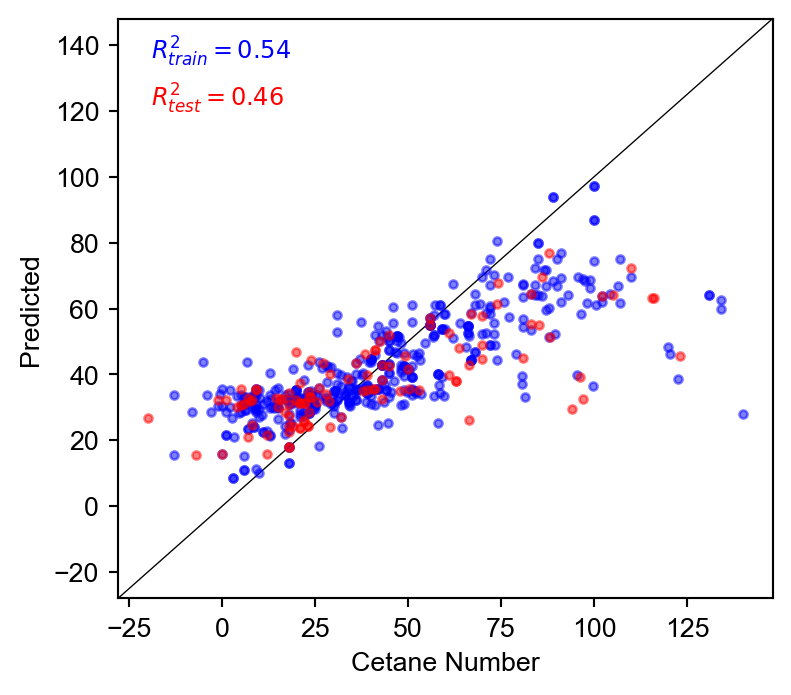

In [17]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel='rbf', C=100, epsilon=5)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            xlabel="Cetane Number", savetitle="../results/rdkit/rdkit_CN.svg") 

## Yield Sooting Index

In [18]:
df = pd.read_csv("../data/data_YSI.csv")
smiles = df.Smiles
Y = df.YSI
print(len(smiles))

610


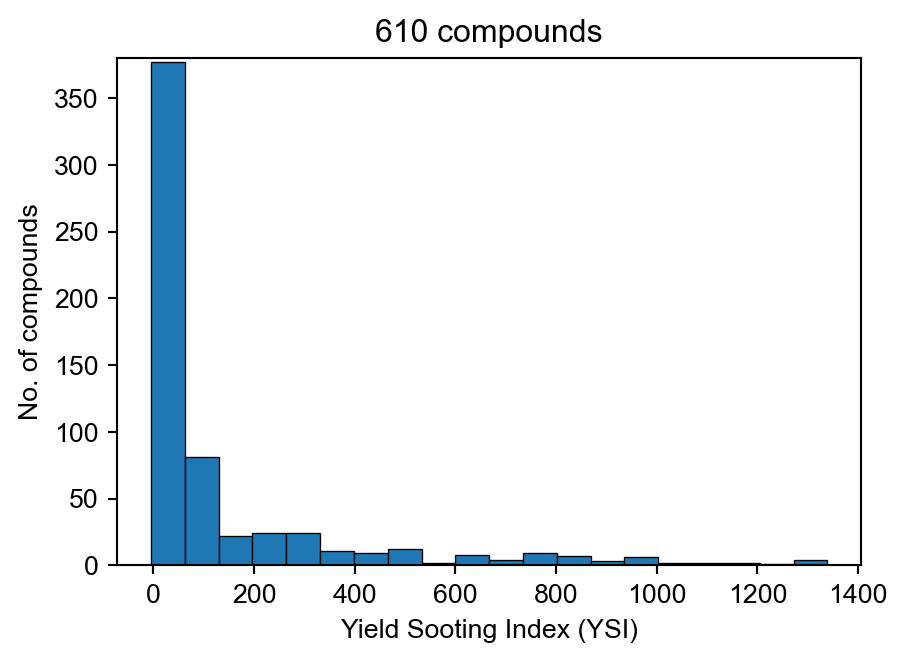

In [19]:
plot_histogram(Y, xlabel="Yield Sooting Index (YSI)")

In [20]:
D, idx = smiles_to_descriptors(smiles)

Y = Y[idx]

In [21]:
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)

In [22]:
%%time

regr = LinearRegression()

sfs = SequentialFeatureSelector(regr, n_features_to_select=15)
sfs.fit(D_train, y_train)
print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}")

Features selected by forward sequential selection: ['BertzCT', 'Chi3n', 'PEOE_VSA7', 'SMR_VSA2', 'SMR_VSA9', 'SlogP_VSA8', 'EState_VSA7', 'VSA_EState4', 'FractionCSP3', 'NumAliphaticCarbocycles', 'NumAromaticCarbocycles', 'NumHeteroatoms', 'fr_Ar_OH', 'fr_NH2', 'fr_para_hydroxylation']
Wall time: 1min 5s


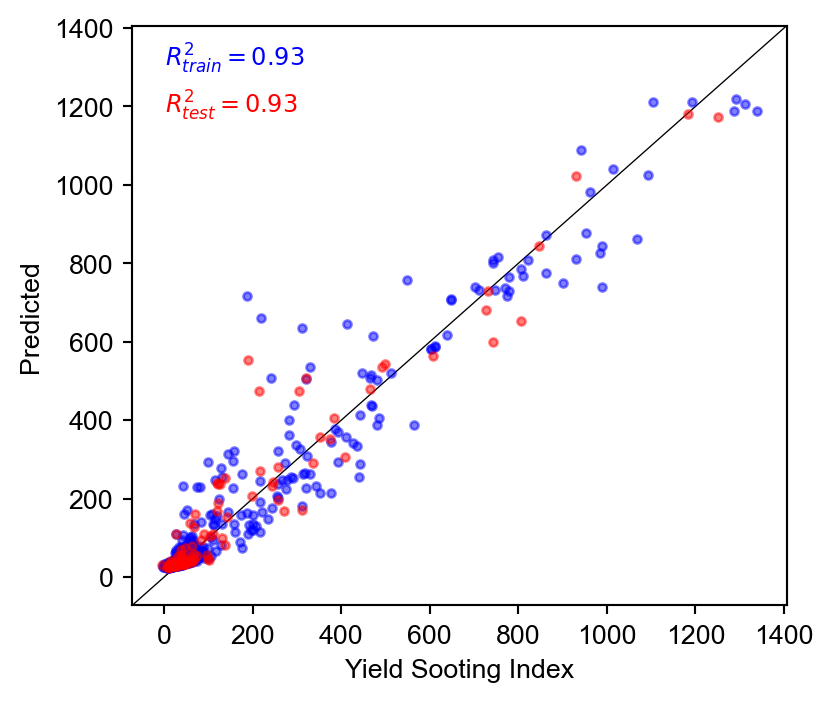

In [23]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel='rbf', C=500, epsilon=20)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Yield Sooting Index", savetitle="../results/rdkit/rdkit_YSI.svg") 

##  Melting Point (MP)

In [24]:
df = pd.read_csv("../data/data_MP.csv")
smiles = df.Smiles
Y = df.mpC
print(len(smiles))

27976


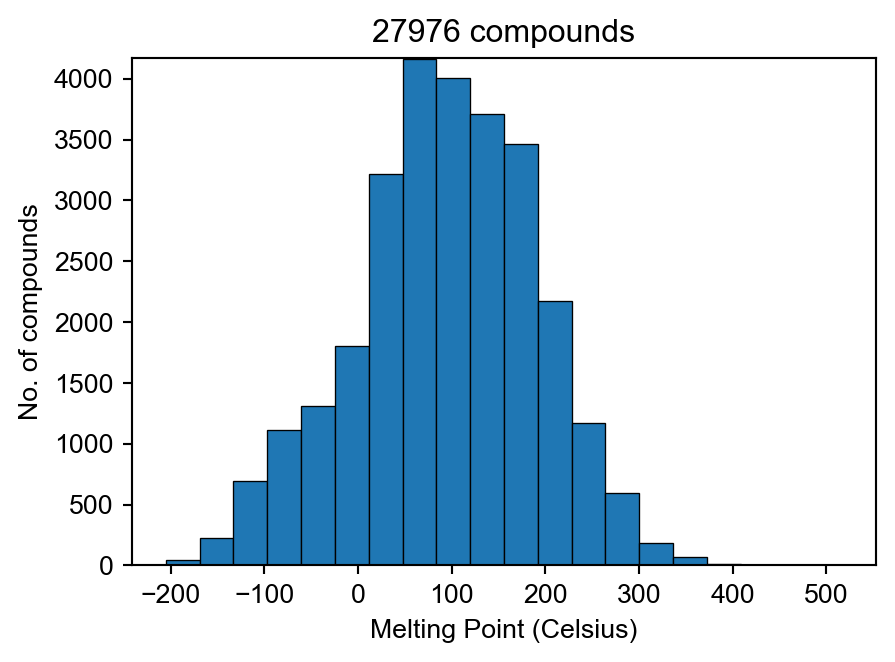

In [25]:
plot_histogram(Y, xlabel="Melting Point (Celsius)")

In [28]:
%%capture

D, idx = smiles_to_descriptors(list(smiles))

Y = Y[idx]

In [29]:
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)

This dataset is too big to use the SequentialFeatureSelector directly. Let us downsample it for the feature selection step:

In [30]:
idx = np.random.choice(range(len(D_train)), size=3000, replace=False)

D_train_downsampled = D_train.iloc[idx]
y_train_downsampled = y_train.iloc[idx]

In [31]:
%%time

regr = LinearRegression()

sfs = SequentialFeatureSelector(regr, n_features_to_select=15, cv=5, n_jobs=5)
sfs.fit(D_train_downsampled, y_train_downsampled)
print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}")

Features selected by forward sequential selection: ['MaxEStateIndex', 'MinAbsEStateIndex', 'FpDensityMorgan1', 'BertzCT', 'Chi0', 'Kappa1', 'SMR_VSA10', 'SMR_VSA3', 'EState_VSA5', 'FractionCSP3', 'NHOHCount', 'NumAliphaticCarbocycles', 'fr_Ar_NH', 'fr_COO2', 'fr_priamide']
Wall time: 1min 36s


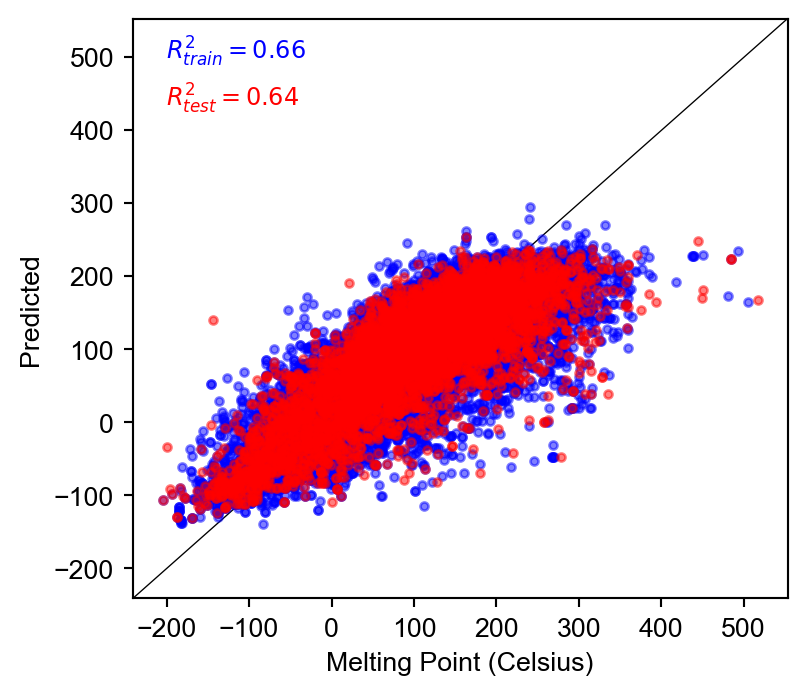

In [32]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel = "rbf", C=500, epsilon=20)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Melting Point (Celsius)", savetitle="../results/rdkit/rdkit_MP.svg") 

## Flash Point (FP)

In [33]:
df = pd.read_csv("../data/data_FP.csv")
smiles = df.Smiles
Y = df.FP
print(len(smiles))

631


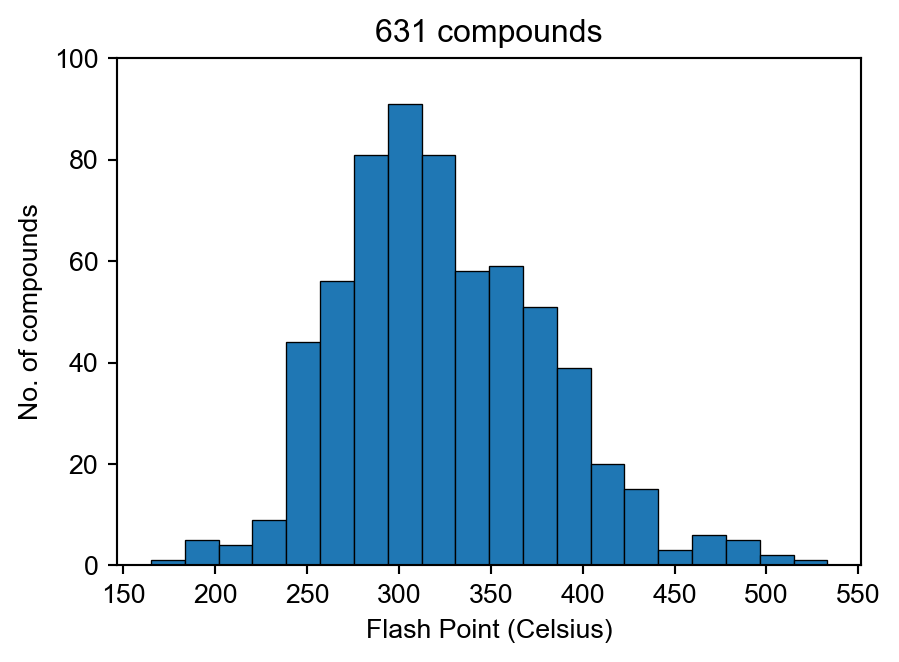

In [34]:
plot_histogram(Y, xlabel="Flash Point (Celsius)")

In [35]:
D, idx = smiles_to_descriptors(smiles)

Y = Y[idx]

In [36]:
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)

In [37]:
%%time

regr = LinearRegression()

sfs = SequentialFeatureSelector(regr, n_features_to_select=15)
sfs.fit(D_train, y_train)
print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}")

Features selected by forward sequential selection: ['HeavyAtomMolWt', 'FpDensityMorgan1', 'FpDensityMorgan3', 'BCUT2D_CHGLO', 'Chi0', 'SMR_VSA6', 'EState_VSA8', 'VSA_EState3', 'VSA_EState4', 'FractionCSP3', 'NHOHCount', 'NumAliphaticHeterocycles', 'NumSaturatedCarbocycles', 'fr_allylic_oxid', 'fr_aryl_methyl']
Wall time: 1min 1s


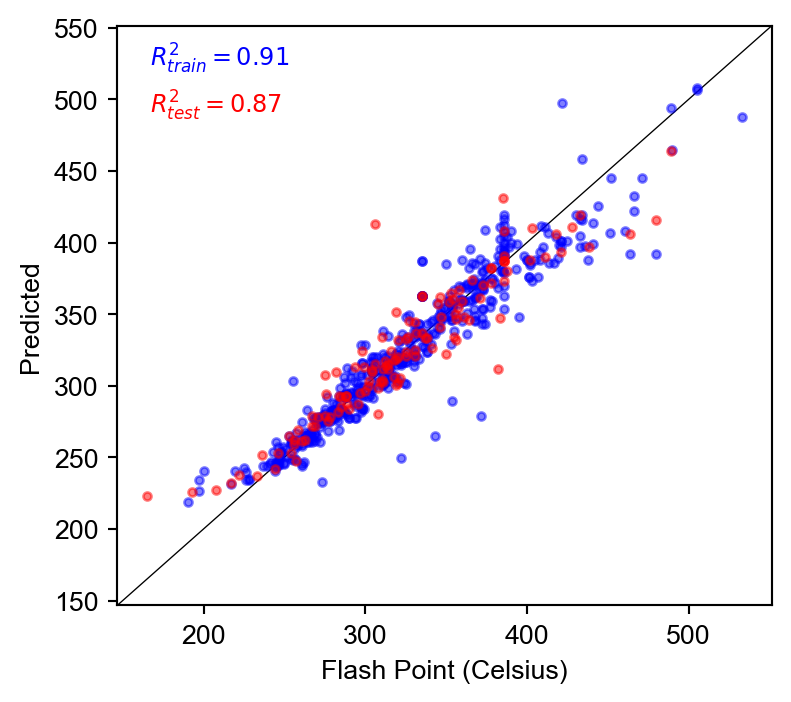

In [38]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel='rbf', C=300, epsilon=5)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Flash Point (Celsius)", savetitle="../results/rdkit/rdkit_FP.svg") 

## Histamine receptor pKi

In [39]:
df = pd.read_csv("../data/data_H1.csv")
Y = df.pKi
smiles = df.Smiles
print(len(smiles))

1214


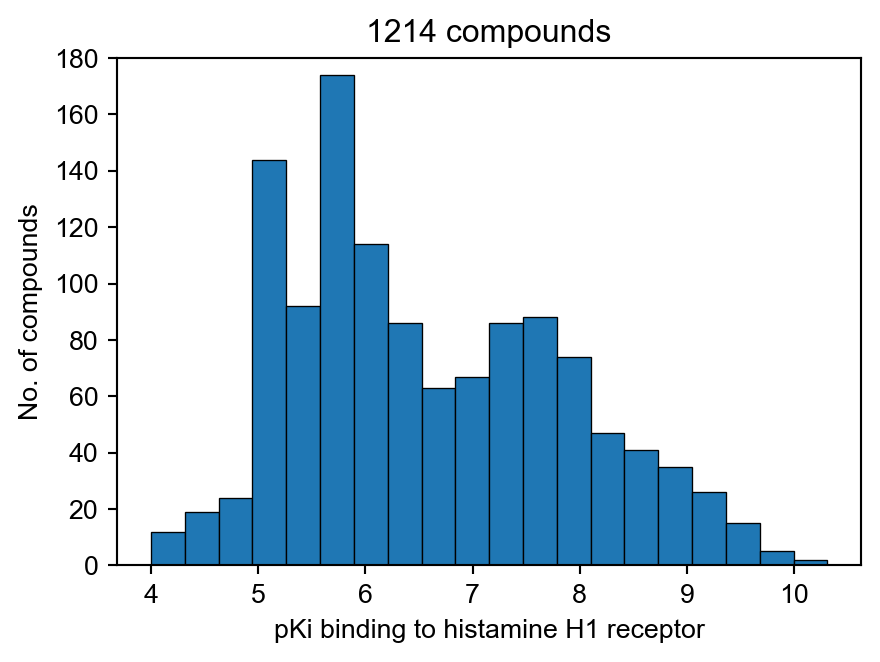

In [40]:
plot_histogram(Y, xlabel="pKi binding to histamine H1 receptor")

In [41]:
D, idx = smiles_to_descriptors(smiles)

Y = Y[idx]

In [42]:
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)

In [43]:
%%time

regr = LinearRegression()

sfs = SequentialFeatureSelector(regr, n_features_to_select=15)
sfs.fit(D_train, y_train)
print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}")

Features selected by forward sequential selection: ['MinAbsEStateIndex', 'BalabanJ', 'HallKierAlpha', 'PEOE_VSA9', 'SMR_VSA7', 'SMR_VSA9', 'EState_VSA7', 'VSA_EState9', 'NHOHCount', 'NOCount', 'fr_Ndealkylation1', 'fr_ketone_Topliss', 'fr_methoxy', 'fr_para_hydroxylation', 'fr_piperdine']
Wall time: 1min 13s


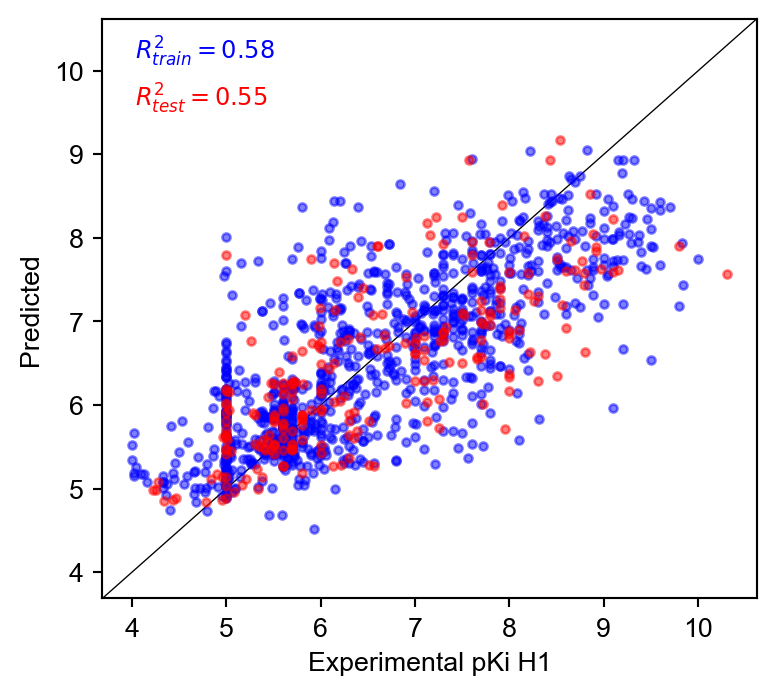

In [44]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel = "rbf", C=10, epsilon = .1)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)


# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel='Experimental pKi H1', savetitle="../results/rdkit/rdkit_H1.svg") 

## Muscarinic receptor pKi

In [45]:
df = pd.read_csv("../data/data_M2.csv")
Y = df.pKi
smiles = df.Smiles
print(len(smiles))

1145


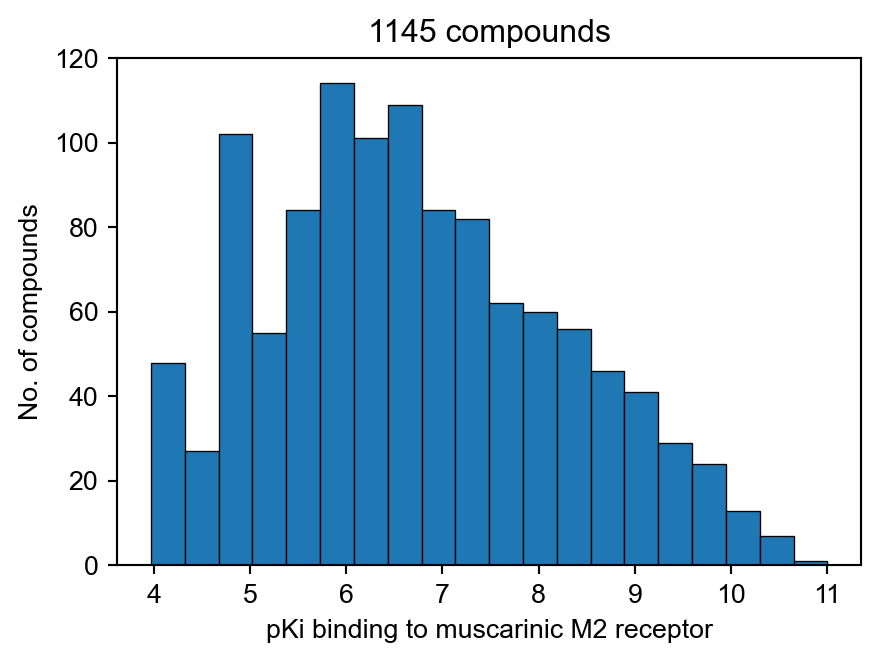

In [46]:
plot_histogram(Y, xlabel="pKi binding to muscarinic M2 receptor")

In [47]:
D, idx = smiles_to_descriptors(smiles)

Y = Y[idx]

In [48]:
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)

In [49]:
%%time

regr = LinearRegression()

sfs = SequentialFeatureSelector(regr, n_features_to_select=15)
sfs.fit(D_train, y_train)
print("Features selected by forward sequential selection: "
      f"{D.columns[sfs.get_support()].tolist()}")

Features selected by forward sequential selection: ['FpDensityMorgan1', 'FpDensityMorgan2', 'Chi3v', 'PEOE_VSA5', 'SlogP_VSA3', 'SlogP_VSA5', 'SlogP_VSA8', 'EState_VSA3', 'VSA_EState2', 'FractionCSP3', 'MolLogP', 'fr_aryl_methyl', 'fr_halogen', 'fr_sulfonamd', 'fr_sulfone']
Wall time: 1min 9s


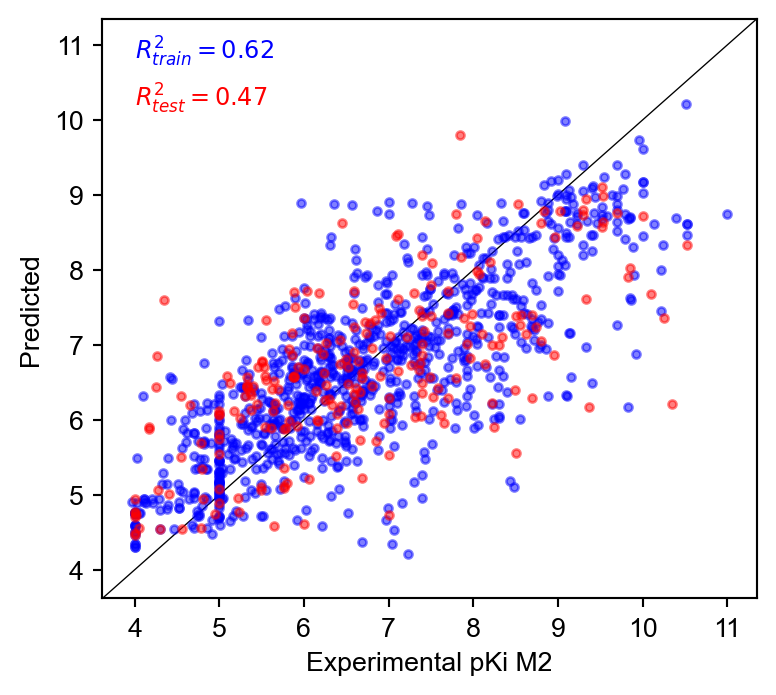

In [50]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel='rbf', C=10, epsilon=.3)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Experimental pKi M2", savetitle="../results/rdkit/rdkit_M2.svg")